<a href="https://colab.research.google.com/github/RabinSharma25/emotion-classification-using-eeg-signals/blob/main/rabin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import the required libraries
import os
import time
import pickle
import pandas as pd
import numpy as np
from google.colab import drive

#for feature extraction
from scipy.signal import welch
from scipy.integrate import simps

#classifier libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB


from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

import xgboost as xgb

from sklearn import model_selection
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve

In [2]:
def read_data(filename):
    x = pickle._Unpickler(open(filename, 'rb'))
    x.encoding = 'latin1'
    p = x.load()
    return p

In [3]:
#creating the file names of the dataset to load it
files = []
for n in range (1, 33):
    s = 's'
    if n < 10:
        s += '0'
    s += str(n)
    s+=str(".dat")
    files.append(s)
print(files)

['s01.dat', 's02.dat', 's03.dat', 's04.dat', 's05.dat', 's06.dat', 's07.dat', 's08.dat', 's09.dat', 's10.dat', 's11.dat', 's12.dat', 's13.dat', 's14.dat', 's15.dat', 's16.dat', 's17.dat', 's18.dat', 's19.dat', 's20.dat', 's21.dat', 's22.dat', 's23.dat', 's24.dat', 's25.dat', 's26.dat', 's27.dat', 's28.dat', 's29.dat', 's30.dat', 's31.dat', 's32.dat']


In [4]:
# 32x40 = 1280 trials for 32 participants
labels = []
data = []
drive.mount('/content/drive')
for i in files:
  filename = "/content/drive/My Drive/major-project/major-project-dataset/" + i
  trial = read_data(filename)
  labels.append(trial['labels'])
  data.append(trial['data'])


Mounted at /content/drive


In [5]:
# Lets see the shapes of the raw data
labels = np.array(labels)
data = np.array(data)
print("Labels: ", labels.shape) # participants x videos x labels
print("Data: ", data.shape) # participants x videos x channels x data

Labels:  (32, 40, 4)
Data:  (32, 40, 40, 8064)


In [6]:
# Re-shape arrays into desired shapes
labels = labels.flatten()
labels = labels.reshape(1280, 4)

data = data.flatten()
data = data.reshape(1280, 40, 8064)

In [7]:
# Double-check the new arrays
#Here trial = participants x vidoes = 32 x 40 = 1280

print("Labels: ", labels.shape) # trial x label
print("Data: ", data.shape) # trial x channel x data

Labels:  (1280, 4)
Data:  (1280, 40, 8064)


In [8]:
#creating the dataframes for the labels
labelsDf = pd.DataFrame(labels)
print("printing the labels dataframe\n")
print(labelsDf)
print("\n\nDescribing the labels dataframe")
labelsDf.describe()

printing the labels dataframe

         0     1     2     3
0     7.71  7.60  6.90  7.83
1     8.10  7.31  7.28  8.47
2     8.58  7.54  9.00  7.08
3     4.94  6.01  6.12  8.06
4     6.96  3.92  7.19  6.05
...    ...   ...   ...   ...
1275  3.91  6.96  5.82  3.12
1276  2.81  6.13  6.06  1.04
1277  3.05  7.01  5.10  1.10
1278  3.99  7.17  4.85  1.00
1279  7.15  4.03  9.00  1.88

[1280 rows x 4 columns]


Describing the labels dataframe


,0,1,2,3
count,1280.000000,1280.000000,1280.000000,1280.000000
mean,5.254313,5.156711,5.382750,5.518133
std,2.130816,2.020499,2.096321,2.282780
min,1.000000,1.000000,1.000000,1.000000
25%,3.867500,3.762500,3.932500,3.960000
50%,5.040000,5.230000,5.240000,6.050000
75%,7.050000,6.950000,7.040000,7.090000
max,9.000000,9.000000,9.000000,9.000000


In [9]:
#giving names to the label columns
labelsDf= pd.DataFrame({'Valence': labels[:,0], 'Arousal': labels[:,1], 'Dominance': labels[:,2], 'Liking': labels[:,3]})
print(labelsDf.describe())


           Valence      Arousal    Dominance       Liking
count  1280.000000  1280.000000  1280.000000  1280.000000
mean      5.254313     5.156711     5.382750     5.518133
std       2.130816     2.020499     2.096321     2.282780
min       1.000000     1.000000     1.000000     1.000000
25%       3.867500     3.762500     3.932500     3.960000
50%       5.040000     5.230000     5.240000     6.050000
75%       7.050000     6.950000     7.040000     7.090000
max       9.000000     9.000000     9.000000     9.000000


In [10]:
#Dropping the Dominance and Liking columns
labelsDf=labelsDf.drop('Dominance',axis=1)
labelsDf=labelsDf.drop('Liking',axis=1)
print(labelsDf.describe())
# df = df.drop('B', axis=1)

           Valence      Arousal
count  1280.000000  1280.000000
mean      5.254313     5.156711
std       2.130816     2.020499
min       1.000000     1.000000
25%       3.867500     3.762500
50%       5.040000     5.230000
75%       7.050000     6.950000
max       9.000000     9.000000


In [11]:
# Dataset with only Valence column
df_val = labelsDf['Valence']
# Dataset with only Arousal column
df_aro = labelsDf['Arousal']

In [12]:
# Function to check if each trial has positive or negative valence
def positive_valence(trial):
    return 1 if labels[trial,0] >= np.median(labels[:,0]) else 0
# Function to check if each trial has high or low arousal
def high_arousal(trial):
    return 1 if labels[trial,1] >= np.median(labels[:,1]) else 0

In [13]:
# Convert all ratings to boolean values
labels_encoded = []
for i in range (len(labels)):
    labels_encoded.append([positive_valence(i), high_arousal(i)])
labels_encoded = np.reshape(labels_encoded, (1280, 2))
df_labels = pd.DataFrame(data=labels_encoded, columns=["High Valence", "High Arousal"])
print(df_labels.describe())

       High Valence  High Arousal
count   1280.000000   1280.000000
mean       0.531250      0.500000
std        0.499218      0.500195
min        0.000000      0.000000
25%        0.000000      0.000000
50%        1.000000      0.500000
75%        1.000000      1.000000
max        1.000000      1.000000


In [14]:
# Dataset with only Valence column
df_valence = df_labels['High Valence']
# Dataset with only Arousal column
df_arousal = df_labels['High Arousal']

# FEATURE EXTRACTION USING WELCH'S METHOD

In [15]:
eeg_channels = np.array(["Fp1", "AF3", "F3", "F7", "FC5", "FC1", "C3", "T7", "CP5", "CP1", "P3", "P7", "PO3", "O1", "Oz", "Pz", "Fp2", "AF4", "Fz", "F4", "F8", "FC6", "FC2", "Cz", "C4", "T8", "CP6", "CP2", "P4", "P8", "PO4", "O2"])
peripheral_channels = np.array(["hEOG", "vEOG", "zEMG", "tEMG", "GSR", "Respiration belt", "Plethysmograph", "Temperature"])

In [16]:
eeg_data = []
for i in range (len(data)):
  for j in range (len(eeg_channels)):
    eeg_data.append(data[i,j])
eeg_data = np.reshape(eeg_data, (len(data), len(eeg_channels), len(data[0,0])))
print(eeg_data.shape)

(1280, 32, 8064)


In [17]:
peripheral_data = []
for i in range (len(data)):
  for j in range (32,len(data[0])):
    peripheral_data.append(data[i,j])
peripheral_data = np.reshape(peripheral_data, (len(data), len(peripheral_channels), len(data[0,0])))
print(peripheral_data.shape)

(1280, 8, 8064)


In [18]:
def bandpower(data, sf, band, window_sec=None, relative=False):
    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

In [19]:
def get_band_power(trial, channel, band):
  bd = (0,0)

  if (band == "theta"): # drownsiness, emotional connection, intuition, creativity
    bd = (4,8)
  elif (band == "alpha"): # reflection, relaxation
    bd = (8,12)
  elif (band == "beta"): # concentration, problem solving, memory
    bd = (12,30)
  elif (band == "gamma"): # cognition, perception, learning, multi-tasking
    bd = (30,64)

  return bandpower(eeg_data[trial,channel], 128, bd)


In [20]:
print(get_band_power(0,31,"theta"))
print(get_band_power(0,31,"alpha"))
print(get_band_power(0,31,"beta"))
print(get_band_power(0,31,"gamma"))

5.434119660168186
5.369595513295193
6.286556266834863
0.9879159580139809


# Process new datasets with 6 EEG regions and 4 band power values

In [21]:
# Transform 1280x 32 x 8064 => 1280 x 128
eeg_band_arr = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_band_arr.append(get_band_power(i,j,"theta"))
    eeg_band_arr.append(get_band_power(i,j,"alpha"))
    eeg_band_arr.append(get_band_power(i,j,"beta"))
    eeg_band_arr.append(get_band_power(i,j,"gamma"))
eeg_band_arr = np.reshape(eeg_band_arr, (1280, 128))

In [22]:
frontal = np.array(["F3", "FC1", "Fz", "F4", "FC2"])
parietal = np.array(["P3", "P7", "Pz", "P4", "P8"])
occipital = np.array(["O1", "Oz", "O2", "PO3", "PO4"])
central = np.array(["CP5", "CP1", "Cz", "C4", "C3", "CP6", "CP2"])

In [23]:
eeg_theta = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_theta.append(get_band_power(i,j,"theta"))
eeg_theta = np.reshape(eeg_theta, (1280, 32))

df_theta = pd.DataFrame(data = eeg_theta, columns=eeg_channels)
print(df_theta.describe())

                Fp1           AF3            F3            F7           FC5  \
count   1280.000000   1280.000000   1280.000000   1280.000000   1280.000000   
mean     517.431002    974.493856    795.093910   1515.004071    746.435950   
std     1165.295163   3147.555132   3020.711666   4990.544508   2188.101734   
min        2.698928      1.995398      1.820656      3.283107      1.311200   
25%       23.306027     17.117475     18.392335     30.827191     14.023436   
50%       65.468048     82.102529     60.241953     91.266539     48.704968   
75%      331.636624    304.949248    175.394835    248.308696    218.358248   
max    15524.135098  38122.870846  39431.320394  49272.793208  20182.668545   

               FC1            C3           T7           CP5          CP1  ...  \
count  1280.000000   1280.000000  1280.000000   1280.000000  1280.000000  ...   
mean    345.936665    486.095113   354.004358    664.656754   276.667812  ...   
std     717.328768   1497.636647   641.432373

In [24]:
# Transform 880 x 32 x 8064 => 880 x 32
eeg_alpha = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_alpha.append(get_band_power(i,j,"alpha"))
eeg_alpha = np.reshape(eeg_alpha, (1280, 32))

df_alpha = pd.DataFrame(data = eeg_alpha, columns=eeg_channels)
print(df_alpha.describe())

               Fp1           AF3            F3            F7          FC5  \
count  1280.000000   1280.000000   1280.000000   1280.000000  1280.000000   
mean    173.544174    333.184883    285.545436    573.725974   249.793720   
std     378.371554   1058.758333   1036.330438   1943.692827   702.436934   
min       2.770151      1.793012      1.724442      2.793554     0.975527   
25%      14.082681     10.737435     10.012318     15.888935    10.074042   
50%      33.713172     34.992442     30.026795     38.178299    20.079100   
75%     125.508396    114.334883     73.488279     93.987498    74.040939   
max    5627.906982  12380.702125  12764.724842  20843.070851  6575.781434   

               FC1           C3           T7          CP5          CP1  ...  \
count  1280.000000  1280.000000  1280.000000  1280.000000  1280.000000  ...   
mean    138.011594   170.423962   124.101183   232.750895    97.610644  ...   
std     275.218934   497.507620   200.171342   735.717912   166.43002

In [25]:
# Transform 880 x 32 x 8064 => 880 x 32
eeg_beta = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_beta.append(get_band_power(i,j,"beta"))
eeg_beta = np.reshape(eeg_beta, (1280, 32))

df_beta = pd.DataFrame(data = eeg_beta, columns=eeg_channels)
print(df_beta.describe())

               Fp1          AF3           F3            F7          FC5  \
count  1280.000000  1280.000000  1280.000000   1280.000000  1280.000000   
mean     92.200266   200.684361   193.372441    341.951096   140.642394   
std     176.162562   668.027842   668.771074   1274.679748   386.740178   
min       4.486703     2.650970     2.784376      3.363422     2.788531   
25%      17.999409    13.190613    10.170223     17.951892    11.341571   
50%      34.413828    29.155242    28.120517     33.617573    22.402198   
75%      80.774739   107.619088    59.807546     62.087123    53.162211   
max    3528.485435  5784.160193  5841.475721  14848.700463  3094.687504   

               FC1           C3           T7          CP5          CP1  ...  \
count  1280.000000  1280.000000  1280.000000  1280.000000  1280.000000  ...   
mean     99.397187    96.901859    77.540922   137.387625    55.047411  ...   
std     197.556641   247.621839    90.107877   409.366974    85.846400  ...   
min     

In [26]:
# Transform 880 x 32 x 8064 => 880 x 32
eeg_gamma = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_gamma.append(get_band_power(i,j,"gamma"))
eeg_gamma = np.reshape(eeg_gamma, (1280, 32))

df_gamma = pd.DataFrame(data = eeg_gamma, columns=eeg_channels)
print(df_gamma.describe())

               Fp1          AF3           F3           F7          FC5  \
count  1280.000000  1280.000000  1280.000000  1280.000000  1280.000000   
mean     50.663247   150.492372   149.210824   122.775294    91.633571   
std     135.591365   645.635199   632.049548   496.744509   340.562025   
min       1.069233     1.119910     0.791859     1.177512     0.712624   
25%       8.292302     5.605668     4.352724     7.591098     5.172920   
50%      18.329100    14.069330    11.828027    15.919877    12.648067   
75%      39.995543    43.454610    28.586812    36.456420    38.094737   
max    3213.255538  6060.539788  5758.756812  6348.177208  3472.515858   

               FC1           C3           T7          CP5          CP1  ...  \
count  1280.000000  1280.000000  1280.000000  1280.000000  1280.000000  ...   
mean     60.487715    56.236468    43.792285    77.048369    29.250057  ...   
std     139.230040   180.285647    62.089299   267.809883    68.503827  ...   
min       0.69492

In [27]:
# Split the data into training/testing sets
def split_train_test(x, y):
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
  return x_train, x_test, y_train, y_test

In [28]:
# Feature scaling
def feature_scaling(train, test):
  sc = StandardScaler()
  train = sc.fit_transform(train)
  test = sc.transform(test)
  return train, test

In [29]:
band_names = np.array(["theta", "alpha", "beta", "gamma"])
channel_names = np.array(["frontal",  "central", "parietal", "occipital"])
label_names = np.array(["valence", "arousal"])

In [30]:
# Testing different kernels (linear, sigmoid, rbf, poly) to select the most optimal one
clf_svm = SVC(kernel = 'rbf', random_state = 42, probability=True)

In [31]:
# Testing different k (odd) numbers, algorithm (auto, ball_tree, kd_tree) and weight (uniform, distance) to select the most optimal one
clf_knn = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='auto')

In [32]:
clf_dtree=DecisionTreeClassifier(max_depth=20,min_samples_split=4)

In [33]:
clf_rf=RandomForestClassifier(n_estimators=50,max_depth=20,min_samples_split=5)

In [34]:
clf_nb= GaussianNB()

In [35]:
# Testing different learning rate (alpha), solver (adam, sgd, lbfgs) and activation (relu, tanh, logistic) to select the most optimal one
clf_mlp = MLPClassifier(solver='adam', activation='tanh', alpha=0.3, max_iter=400)

In [36]:
clf_adaboost = AdaBoostClassifier(n_estimators=50, random_state=42)


In [37]:
clf_xgb = xgb.XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=100, random_state=42)


In [38]:
import lightgbm as lgb
clf_lgbm = lgb.LGBMClassifier()

In [39]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
clf_gpc = GaussianProcessClassifier(kernel=1.0 * RBF(length_scale=1.0), random_state=42)


In [40]:
from sklearn.linear_model import Perceptron
clf_perceptron = Perceptron(random_state=42)

In [41]:
!pip install catboost
import catboost as cb
clf_catboost = cb.CatBoostClassifier(iterations=1000, depth=6, learning_rate=0.1, loss_function='Logloss', verbose=0)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.8 MB/s eta 0:00:00


In [42]:
models = []
models.append(('SVM', clf_svm))
models.append(('k-NN', clf_knn))
models.append(('DT', clf_dtree))
models.append(('RF', clf_rf))
models.append(('NB', clf_nb))
models.append(('MLP', clf_mlp))
models.append(('AB', clf_adaboost))
models.append(('XGB', clf_xgb))

In [43]:
def run_clf_cv(band, channel, label, clf):
  if (band == "theta"):
    df_x = df_theta
  elif (band == "alpha"):
    df_x = df_alpha
  elif (band == "beta"):
    df_x = df_beta
  elif (band == "gamma"):
    df_x = df_gamma

  if (channel == "frontal"):
    df_x = df_x[frontal]
  elif (channel == "central"):
    df_x = df_x[central]
  elif (channel == "parietal"):
    df_x = df_x[parietal]
  elif (channel == "occipital"):
    df_x = df_x[occipital]

  df_y = df_arousal if (label == "arousal") else df_valence

  # Train-test split
  x_train, x_test, y_train, y_test = split_train_test(df_x, df_y)

  # Apply CV
  x_for_kfold = np.array(x_train)
  y_for_kfold = np.array(y_train)
  kfold = model_selection.KFold(n_splits=5)

  for i, j in kfold.split(x_for_kfold):
   x_train2, x_test2 = x_for_kfold[i], x_for_kfold[j]
   y_train2, y_test2 = y_for_kfold[i], y_for_kfold[j]

  # Feature scaling
  x_train2, x_test2 = feature_scaling(x_train2, x_test2)

  if (clf == "svm"):
    clf_svm.fit(x_train2, y_train2)
    y_predict = clf_svm.predict(x_test2)
  elif (clf == "knn"):
    clf_knn.fit(x_train2, y_train2)
    y_predict = clf_knn.predict(x_test2)
  elif (clf == "dtree"):
    clf_dtree.fit(x_train2, y_train2)
    y_predict = clf_dtree.predict(x_test2)
  elif (clf == "rf"):
    clf_rf.fit(x_train2, y_train2)
    y_predict = clf_rf.predict(x_test2)
  elif (clf == "nb"):
    clf_nb.fit(x_train2, y_train2)
    y_predict = clf_nb.predict(x_test2)
  elif (clf == "mlp"):
    clf_mlp.fit(x_train2, y_train2)
    y_predict = clf_mlp.predict(x_test2)
  elif (clf == "ab"):
    clf_adaboost.fit(x_train2, y_train2)
    y_predict = clf_adaboost.predict(x_test2)
  elif (clf == "xgb"):
    clf_xgb.fit(x_train2, y_train2)
    y_predict = clf_xgb.predict(x_test2)
  elif (clf == "lgbm"):
    clf_lgbm.fit(x_train2, y_train2)
    y_predict = clf_lgbm.predict(x_test2)
  elif (clf == "gpc"):
    clf_gpc.fit(x_train2, y_train2)
    y_predict = clf_gpc.predict(x_test2)
  elif (clf == "per"):
    clf_perceptron.fit(x_train2, y_train2)
    y_predict = clf_perceptron.predict(x_test2)

  elif (clf == "cb"):
    clf_catboost.fit(x_train2, y_train2)
    y_predict = clf_catboost.predict(x_test2)

  return y_test2, y_predict

In [44]:
def get_accuracy(band, channel, label, clf):
  y_test2, y_predict = run_clf_cv(band, channel, label, clf)
  return np.round(accuracy_score(y_test2, y_predict)*100,2)

In [45]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
def print_conf(band, channel, label, clf):
  y_test2, y_predict = run_clf_cv(band, channel, label, clf)
  conf_matrix = confusion_matrix(y_test2, y_predict)
  # print(conf_matrix)
  plt.figure(figsize=(4, 2))  # Decrease the figure size
  plt.title('Confusion Matrix')
  sns.heatmap(conf_matrix,
              annot=True,
              fmt='g',
              xticklabels=['Not Spam','Spam'],
              yticklabels=['Not Spam','Spam'])

  # display matrix
  plt.ylabel('Actual',fontsize=12)
  plt.xlabel('Prediction',fontsize=12)
  plt.show()

  # printing the classificati# Split the data into training/testing sets
# def split_train_test(x, y):
#   x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
#   return x_train, x_test, y_train, y_test

  class_report = classification_report(y_test2, y_predict, target_names=['Not Spam', 'Spam'])
  print("\nClassification Report:")
  print(class_report)

In [46]:
def print_accuracy(label, clf):
  arr = []
  for i in range (len(band_names)):
    for j in range (len(channel_names)):
      arr.append(get_accuracy(band_names[i], channel_names[j], label, clf))
  arr = np.reshape(arr, (4,4))
  df = pd.DataFrame(data = arr, index=band_names, columns=channel_names)

  #print("Top 3 EEG regions with highest scores")
  #print(df.apply(lambda s: s.abs()).max().nlargest(3))
  #print()
  #print("Top 2 bands with highest scores")
  #print(df.apply(lambda s: s.abs()).max(axis=1).nlargest(2))
  #print()
  #print("EEG region with highest scores per each band")
  #print(df.idxmax(axis=1))
  #print()
  #print("Accuracy Scores")
  #print(df.idxmax())
  #print()
  print(df)

In [47]:

print_accuracy('arousal', 'svm')

       frontal  central  parietal  occipital
theta    52.94    50.00     54.41      50.98
alpha    53.43    50.00     50.00      50.98
beta     52.45    50.00     55.39      50.49
gamma    50.49    52.94     51.96      49.02


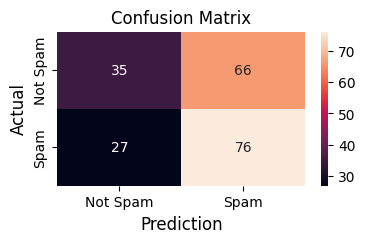


Classification Report:
              precision    recall  f1-score   support

    Not Spam       0.56      0.35      0.43       101
        Spam       0.54      0.74      0.62       103

    accuracy                           0.54       204
   macro avg       0.55      0.54      0.52       204
weighted avg       0.55      0.54      0.53       204



In [48]:
# print the confusion matrix which gives the highest accuracy
print_conf("theta","parietal","arousal","svm")

In [49]:
print_accuracy('valence', 'svm')

       frontal  central  parietal  occipital
theta    55.39    53.92     54.41      55.88
alpha    55.39    54.90     55.39      55.39
beta     54.41    56.86     56.86      56.37
gamma    54.90    58.33     56.37      58.33


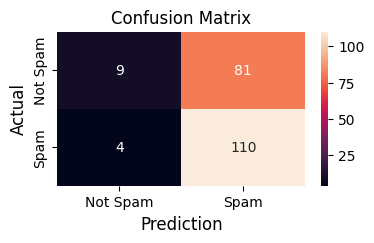


Classification Report:
              precision    recall  f1-score   support

    Not Spam       0.69      0.10      0.17        90
        Spam       0.58      0.96      0.72       114

    accuracy                           0.58       204
   macro avg       0.63      0.53      0.45       204
weighted avg       0.63      0.58      0.48       204



In [50]:
print_conf("gamma","central","valence","svm")

In [51]:
print_accuracy('arousal', 'ab')

       frontal  central  parietal  occipital
theta    60.78    59.31     57.84      60.29
alpha    61.27    59.80     53.43      56.86
beta     64.22    56.37     58.33      56.86
gamma    60.29    55.39     57.84      65.69


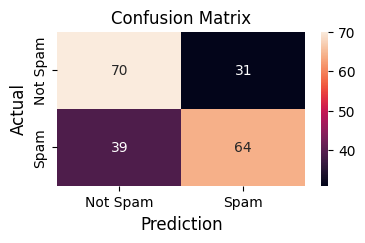


Classification Report:
              precision    recall  f1-score   support

    Not Spam       0.64      0.69      0.67       101
        Spam       0.67      0.62      0.65       103

    accuracy                           0.66       204
   macro avg       0.66      0.66      0.66       204
weighted avg       0.66      0.66      0.66       204



In [52]:
print_conf("gamma","occipital","arousal","ab")

In [53]:
print_accuracy('valence', 'ab')

       frontal  central  parietal  occipital
theta    50.49    55.39     56.86      55.88
alpha    53.92    56.37     57.84      54.90
beta     56.86    56.37     56.86      57.84
gamma    56.37    55.88     50.98      55.88


In [54]:
print_accuracy('arousal', 'xgb')

       frontal  central  parietal  occipital
theta    61.27    59.31     56.86      59.31
alpha    62.75    59.80     63.24      57.84
beta     62.25    56.86     61.76      57.35
gamma    63.73    59.80     55.39      61.27


In [55]:
print_accuracy('valence', 'xgb')

       frontal  central  parietal  occipital
theta    54.90    56.37     56.86      57.84
alpha    55.39    64.22     62.25      57.35
beta     58.82    65.69     58.82      59.80
gamma    57.84    58.33     55.88      59.80


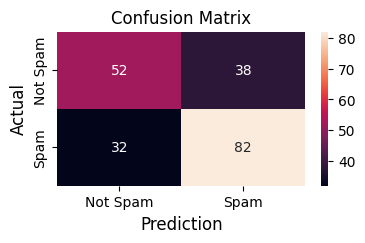


Classification Report:
              precision    recall  f1-score   support

    Not Spam       0.62      0.58      0.60        90
        Spam       0.68      0.72      0.70       114

    accuracy                           0.66       204
   macro avg       0.65      0.65      0.65       204
weighted avg       0.65      0.66      0.66       204



In [56]:
print_conf("beta","central","valence","xgb")

In [57]:
print_accuracy('arousal', 'knn')

       frontal  central  parietal  occipital
theta    62.75    60.78     60.29      62.25
alpha    65.69    64.22     64.22      59.31
beta     61.76    56.86     63.24      55.39
gamma    62.25    61.27     60.29      56.37


In [58]:
print_accuracy('valence', 'knn')

       frontal  central  parietal  occipital
theta    57.84    58.33     51.47      58.33
alpha    55.39    57.84     59.31      53.92
beta     58.82    57.84     61.76      55.39
gamma    64.22    56.86     61.76      54.41


In [59]:
print_accuracy('arousal', 'dtree')

       frontal  central  parietal  occipital
theta    61.27    59.80     56.86      59.31
alpha    58.82    60.29     56.86      53.92
beta     57.35    52.45     51.47      58.33
gamma    60.78    56.37     55.88      61.27


In [60]:
print_accuracy('valence', 'dtree')

       frontal  central  parietal  occipital
theta    53.92    54.90     52.45      52.94
alpha    56.86    56.37     57.84      54.90
beta     52.94    52.94     56.37      61.27
gamma    56.86    57.84     59.31      57.84


In [61]:
print_accuracy('arousal', 'rf')

       frontal  central  parietal  occipital
theta    63.24    62.25     58.33      61.76
alpha    61.76    59.80     62.25      64.22
beta     60.78    62.75     60.29      56.86
gamma    62.75    64.22     56.86      60.78


In [62]:
print_accuracy('valence', 'rf')

       frontal  central  parietal  occipital
theta    54.41    59.31     54.41      60.78
alpha    55.88    61.76     62.75      59.31
beta     58.82    62.75     63.24      59.31
gamma    64.71    58.33     57.35      61.27


In [63]:
print_accuracy('arousal', 'nb')

       frontal  central  parietal  occipital
theta    47.55    52.94     50.00      51.47
alpha    49.02    52.94     50.98      51.47
beta     48.04    50.98     54.41      47.55
gamma    49.02    52.45     51.47      47.55


In [64]:
print_accuracy('valence', 'nb')

       frontal  central  parietal  occipital
theta    56.86    48.04     55.88      56.37
alpha    55.39    47.55     48.53      57.35
beta     54.90    49.51     47.55      55.39
gamma    56.37    56.86     54.90      57.84


In [65]:
print_accuracy('arousal', 'mlp')

       frontal  central  parietal  occipital
theta    50.00    51.47     52.45      54.90
alpha    50.49    50.49     54.90      53.92
beta     51.96    50.00     54.41      54.90
gamma    52.45    51.47     51.96      54.41


In [66]:
print_accuracy('valence', 'mlp')

       frontal  central  parietal  occipital
theta    56.86    55.39     55.39      57.84
alpha    57.84    53.92     56.37      58.33
beta     55.39    56.86     56.86      56.86
gamma    50.98    53.43     55.39      57.35


In [67]:
print_accuracy('arousal', 'lgbm')

[LightGBM] [Info] Number of positive: 407, number of negative: 413
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 820, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496341 -> initscore=-0.014634
[LightGBM] [Info] Start training from score -0.014634
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [68]:
print_accuracy('valence', 'lgbm')

[LightGBM] [Info] Number of positive: 426, number of negative: 394
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 820, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.519512 -> initscore=0.078088
[LightGBM] [Info] Start training from score 0.078088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 426, number of negative: 394
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of

In [69]:
print_accuracy('arousal', 'gpc')

       frontal  central  parietal  occipital
theta    57.84    52.45     61.76      52.45
alpha    65.20    51.47     65.20      53.43
beta     60.29    58.33     62.25      55.88
gamma    63.73    55.88     59.31      63.73


In [70]:
print_accuracy('valence', 'gpc')

       frontal  central  parietal  occipital
theta    55.88    55.88     54.41      54.41
alpha    56.86    56.37     61.76      55.88
beta     56.37    61.76     63.24      56.86
gamma    56.86    63.73     52.94      57.35


In [71]:
print_accuracy('arousal', 'per')

       frontal  central  parietal  occipital
theta    52.45    48.53     53.43      50.00
alpha    49.02    50.00     50.49      50.49
beta     50.98    50.49     51.47      50.49
gamma    50.49    57.84     52.45      50.00


In [72]:
print_accuracy('valence', 'per')

       frontal  central  parietal  occipital
theta    43.63    47.06     48.53      43.14
alpha    43.14    49.02     48.53      44.12
beta     54.41    47.55     44.12      43.63
gamma    44.12    51.47     45.10      46.08


In [73]:
print_accuracy('arousal', 'cb')

       frontal  central  parietal  occipital
theta    60.78    59.31     52.94      62.25
alpha    65.20    63.73     57.84      62.25
beta     60.29    54.90     56.86      55.88
gamma    66.67    59.31     60.29      64.71


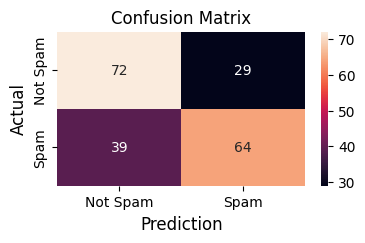


Classification Report:
              precision    recall  f1-score   support

    Not Spam       0.65      0.71      0.68       101
        Spam       0.69      0.62      0.65       103

    accuracy                           0.67       204
   macro avg       0.67      0.67      0.67       204
weighted avg       0.67      0.67      0.67       204



In [74]:
print_conf("gamma","frontal","arousal","cb")

In [75]:
print_accuracy('valence', 'cb')

       frontal  central  parietal  occipital
theta    54.90    56.37     55.88      61.27
alpha    55.88    58.33     56.37      55.88
beta     60.78    61.27     59.31      62.75
gamma    58.82    58.33     57.84      59.80
